# Drug Usage Analysis

## Import Python Packages and Dataset

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.metrics import matthews_corrcoef, confusion_matrix, balanced_accuracy_score,precision_score,recall_score,f1_score,accuracy_score,roc_auc_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")
random.seed(8888)

In [2]:
df = pd.read_csv("drug_consumption.csv",index_col=["ID"])
df.head(5)

,Age,Gender,Education,Country,Ethnicity,NScore,EScore,OScore,AScore,CScore,...,Semer,VSA,Depress,Stim,Hallu,monthly_u,weekly_u,daily_u,Legal,Illegal
ID,,,,,,,,,,,,,,,,,,,,,
2.0,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,...,CL0,CL0,0,1,0,1,0,0,0,1
3.0,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,...,CL0,CL0,0,0,0,0,0,0,1,0
4.0,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,...,CL0,CL0,0,0,0,0,0,0,1,0
5.0,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,...,CL0,CL0,0,0,0,0,0,0,1,0
6.0,2.59171,0.48246,-1.22751,0.24923,-0.31685,-0.67825,-0.30033,-1.55521,2.03972,1.63088,...,CL0,CL0,0,0,0,0,0,0,1,0


## Initial Summary statistics

### Categorical Features

In [3]:
age = df["Age"].value_counts()
age/sum(age)

-0.95197    0.341295
-0.07854    0.255308
 0.49788    0.188429
 1.09449    0.156051
 1.82213    0.049363
 2.59171    0.009554
Name: Age, dtype: float64

In [4]:
gender = df["Gender"].value_counts()
gender/sum(gender)

-0.48246    0.500531
 0.48246    0.499469
Name: Gender, dtype: float64

In [5]:
country = df["Country"].value_counts()
country/sum(country)

 0.96082    0.553609
-0.57009    0.295648
-0.28519    0.062633
 0.24923    0.046178
-0.09765    0.028662
 0.21128    0.010616
-0.46841    0.002654
Name: Country, dtype: float64

In [6]:
edu = df["Education"].value_counts()
edu/sum(edu)

-0.61113    0.268577
 0.45468    0.254777
 1.16365    0.150212
-0.05921    0.142781
-1.22751    0.053079
-1.73790    0.052548
 1.98437    0.047240
-1.43719    0.015924
-2.43591    0.014862
Name: Education, dtype: float64

In [7]:
eth = df["Ethnicity"].value_counts()
eth/sum(eth)

-0.31685    0.912951
 0.11440    0.033439
-1.10702    0.017516
-0.50212    0.013800
-0.22166    0.010616
 0.12600    0.010085
 1.90725    0.001592
Name: Ethnicity, dtype: float64

### Continuous features

In [8]:
ffm_desc = {"min":[],"25":[],"50":[],"75":[],"max":[]}
psy = ["NScore","EScore","OScore","AScore","CScore","Impulsive","SS"]
for i in psy:
    ffm_desc["min"].append(df[i].describe()[3])
    ffm_desc["25"].append(df[i].describe()[4])
    ffm_desc["50"].append(df[i].describe()[5])
    ffm_desc["75"].append(df[i].describe()[6])
    ffm_desc["max"].append(df[i].describe()[7])
    
psy_summary = pd.DataFrame.from_dict(ffm_desc)
psy_summary.index = psy
psy_summary.head(7)

,min,25,50,75,max
NScore,-3.46436,-0.67825,0.04257,0.62967,3.27393
EScore,-3.27393,-0.69509,0.00332,0.63779,3.27393
OScore,-3.27393,-0.71727,-0.01928,0.72330,2.90161
AScore,-3.46436,-0.60633,-0.01729,0.76096,3.46436
CScore,-3.46436,-0.65253,-0.00665,0.58489,3.46436
Impulsive,-2.55524,-0.71126,-0.21712,0.52975,2.90161
SS,-2.07848,-0.52593,0.07987,0.76540,1.92173


### Group Classifications

#### Users vs Non-Users

0    1156
1     728
Name: monthly_u, dtype: int64


([<matplotlib.patches.Wedge at 0x20bdcbaec88>,
 [Text(-0.38425430483768697, 1.0307029781725219, 'Non-Users'),
  Text(0.38425420833630763, -1.030703014149002, 'Users')],
 [Text(-0.20959325718419286, 0.5622016244577391, '61.4%'),
  Text(0.20959320454707686, -0.5622016440812737, '38.6%')])

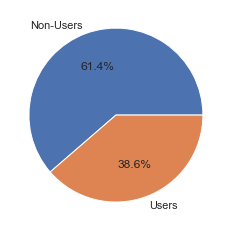

In [9]:
print(df["monthly_u"].value_counts())
plt.pie([1156,728],labels=["Non-Users","Users"],autopct="%.1f%%") 

#### Drug Classes

([<matplotlib.patches.Wedge at 0x20bdcc3c588>,
 [Text(0.3382831028848415, 1.046692190809984, 'Depressants'),
  Text(-0.9483006507870193, -0.557427910780323, 'Stimulants'),
  Text(0.8220450594615275, -0.7309185455404001, 'Hallucinogens')],
 [Text(0.18451805611900443, 0.5709230131690821, '40.0%'),
  Text(-0.5172549004292832, -0.304051587698358, '36.8%'),
  Text(0.44838821425174225, -0.3986828430220364, '23.1%')])

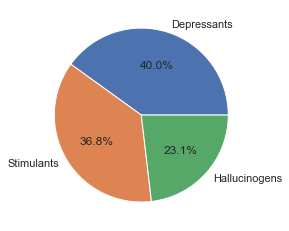

In [10]:
plt.pie([sum(df["Depress"]),sum(df["Stim"]),sum(df["Hallu"])],labels=["Depressants","Stimulants","Hallucinogens"],autopct="%.1f%%")

([<matplotlib.patches.Wedge at 0x20bdcc86448>,
 [Text(0.032596635354350825, 1.0995169209082576, 'Monthly Users'),
  Text(-0.6145113650224875, -0.9123463061021289, 'Weekly Users'),
  Text(0.930155667647423, -0.5872056147069584, 'Daily Users')],
 [Text(0.017779982920554993, 0.599736502313595, '49.1%'),
  Text(-0.33518801728499314, -0.49764343969207026, '33.0%'),
  Text(0.5073576368985943, -0.3202939716583409, '17.9%')])

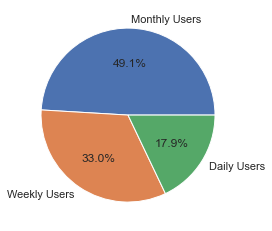

In [11]:
plt.pie([sum(df["monthly_u"]),sum(df["weekly_u"]),sum(df["daily_u"])],labels=["Monthly Users","Weekly Users","Daily Users"],autopct="%.1f%%")

#### Legal and Illegal Drug Users

([<matplotlib.patches.Wedge at 0x1efd3321d88>,
 [Text(-0.770064146725806, 0.7854942456361195, 'Legal'),
  Text(0.7700640731825233, -0.7854943177347252, 'Illegal')],
 [Text(-0.4200349891231669, 0.42845140671061055, '74.7%'),
  Text(0.42003494900864907, -0.4284514460371228, '25.3%')])

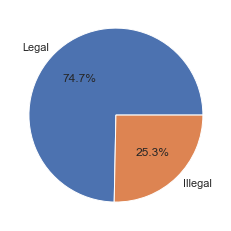

In [11]:
plt.pie([sum(df["Legal"]),sum(df["Illegal"])],labels=["Legal","Illegal"],autopct="%.1f%%")

## Determine which factors are important in predicting drug use
* Use Random Forest Feature Importance
* Input Feature Ranking Methods
* Correlation Matrix 

#### Correlation Matrix

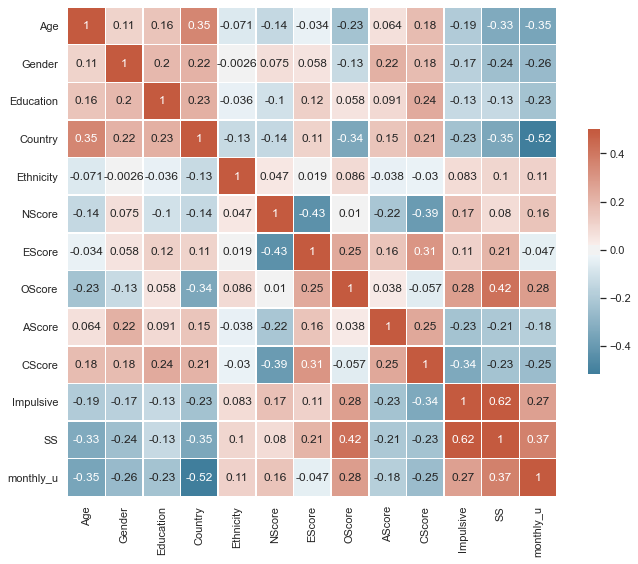

In [12]:
## Correlation Matrix
feat_df = df[["Age","Gender","Education","Country","Ethnicity","NScore","EScore","OScore","AScore","CScore","Impulsive","SS","monthly_u"]]
corr = feat_df.corr()

#Genrate mask for upper triangle
mask = np.triu(np.ones_like(corr,dtype=bool))
#Plot
fig,ax = plt.subplots(figsize=(11,9))
cmap = sns.diverging_palette(230,20, as_cmap=True)

sns.heatmap(corr,cmap=cmap,vmax=0.5,center=0,square=True,linewidth=.5, cbar_kws={"shrink":.5},annot=True)

* Significant Negative Correlations: Country(-0.53), Age(-0.37), Gender(-0.27), Education(-0.24)
* Significant Positive Correlations: OScore(0.3), Impuslive(0.29), Sensation Seeking(0.39)


#### Random Forest Feature Ranking

In [14]:
#Perform Feature Importance ranking using RandomForest
##Split Dataset into test train
np.random
x = df.iloc[:,0:12]
y = df.monthly_u
train_x,test_x,train_y,test_y = train_test_split(x,y,test_size=0.2)

rf = RandomForestClassifier(n_estimators=1400,oob_score=True,max_features="auto",min_samples_leaf=1)
rf.fit(train_x,train_y)
predict_class = rf.predict(test_x)
mcc = matthews_corrcoef(test_y,predict_class)
acc = balanced_accuracy_score(test_y,predict_class)
pre = precision_score(test_y,predict_class,average="weighted")
rec = recall_score(test_y,predict_class,average="weighted")
f1 = f1_score(test_y,predict_class,average="weighted")
roc = roc_auc_score(test_y,predict_class)

print(f"MCC: {mcc}\nAccuracy: {acc}\nPrecision: {pre}\nRecall: {rec}\nF1: {f1}\nROC: {roc}")

MCC: 0.5038442648228193
Accuracy: 0.752748602665684
Precision: 0.7726750957710533
Recall: 0.7718832891246684
F1: 0.7722568503132766
ROC: 0.7527486026656839


Text(0, 0.5, 'Features')

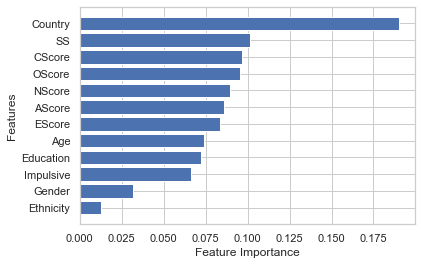

In [15]:
features = x.columns.to_list()
importances = rf.feature_importances_
indices = np.argsort(importances)
plt.barh(range(len(indices)),importances[indices],color="b")
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel("Feature Importance")
plt.ylabel("Features")

#### PCA 

In [16]:
# Perform PCA without scaling data
pca = PCA(n_components=1)
pca.fit(x)
loadings=pd.DataFrame(pca.components_,columns=x.columns.to_list())
loadings=loadings.transpose()
loadings=loadings.abs()
loadings=loadings.sort_values(by =0,ascending=False)
print(loadings)

                  0
SS         0.444405
Impulsive  0.436545
CScore     0.415750
NScore     0.306004
AScore     0.291553
OScore     0.267066
Age        0.266403
Country    0.234640
Education  0.212464
EScore     0.094660
Gender     0.094001
Ethnicity  0.012460


In [17]:
#Scaled Data
from sklearn import preprocessing
pca = PCA(n_components=1)
X = preprocessing.scale(x)
pca.fit(X)
Eloadings=loadings.transpose()
loadings=loadings.abs()
loadings=loadings.sort_values(by =0,ascending=False)
print(loadings)

                  0
SS         0.444405
Impulsive  0.436545
CScore     0.415750
NScore     0.306004
AScore     0.291553
OScore     0.267066
Age        0.266403
Country    0.234640
Education  0.212464
EScore     0.094660
Gender     0.094001
Ethnicity  0.012460


In [18]:
# Pivot table to see if there is difference in frequnecy between no. of male drug users and non users vs female drug users
user = df[df["monthly_u"]==1]
non = df[df["monthly_u"]==0]
print(user["Gender"].value_counts()/sum(user["Gender"].value_counts()))
print(non["Gender"].value_counts()/sum(non["Gender"].value_counts()))

-0.48246    0.666209
 0.48246    0.333791
Name: Gender, dtype: float64
 0.48246    0.603806
-0.48246    0.396194
Name: Gender, dtype: float64


In [19]:
print(user["Country"].value_counts()/sum(user["Country"].value_counts()))
print(non["Country"].value_counts()/sum(non["Country"].value_counts()))

-0.57009    0.545330
 0.96082    0.233516
-0.28519    0.083791
 0.24923    0.060440
-0.09765    0.056319
 0.21128    0.015110
-0.46841    0.005495
Name: Country, dtype: float64
 0.96082    0.755190
-0.57009    0.138408
-0.28519    0.049308
 0.24923    0.037197
-0.09765    0.011246
 0.21128    0.007785
-0.46841    0.000865
Name: Country, dtype: float64


In [20]:
print(user["Ethnicity"].value_counts()/sum(user["Ethnicity"].value_counts()))
print(non["Ethnicity"].value_counts()/sum(non["Ethnicity"].value_counts()))

-0.31685    0.912088
 0.11440    0.046703
 0.12600    0.013736
-0.22166    0.012363
-1.10702    0.006868
 1.90725    0.004121
-0.50212    0.004121
Name: Ethnicity, dtype: float64
-0.31685    0.913495
 0.11440    0.025087
-1.10702    0.024221
-0.50212    0.019896
-0.22166    0.009516
 0.12600    0.007785
Name: Ethnicity, dtype: float64


Removed Country, Ethnicity, Gender, Age, Education from modelling work
* Country of origin, Gender, Ethnicity,Education,Age not important in describing drug use based on personality traits.

## What are the difference in psychological profiles between users and non-users
* Compare distribution of psychological profiles between users and non-users
* Run logistic regression and see weight coefficients for all psychological features and infer differences based on coefficients. 

In [21]:
from sklearn.linear_model import LogisticRegression 
from imblearn.over_sampling import SMOTE,SMOTENC

### Checking Assumptions
* Binary Response
* Observations must be independent of one another
* Little or no multicolinearity among independent variables
* Linearity

#### Multicolinearity among independent variables

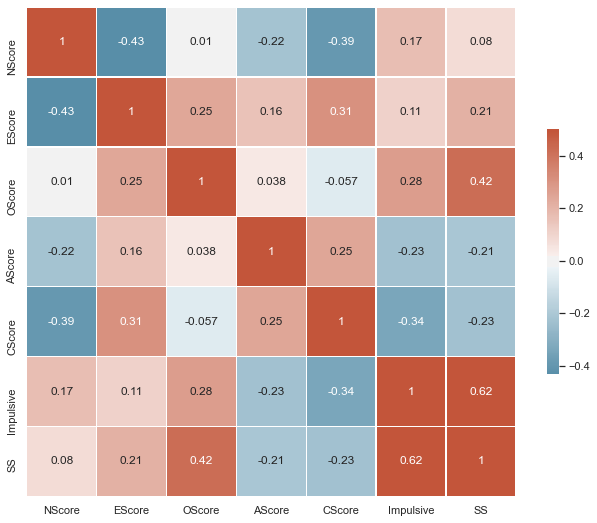

In [22]:
profile_corr = corr.iloc[5:12,5:12]
mask = np.triu(np.ones_like(profile_corr,dtype=bool))
#Plot
fig,ax = plt.subplots(figsize=(11,9))
cmap = sns.diverging_palette(230,20, as_cmap=True)

sns.heatmap(profile_corr,cmap=cmap,vmax=0.5,center=0,square=True,linewidth=.5, cbar_kws={"shrink":.5},annot=True)

In [23]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

profile_df = df.iloc[:,0:12]
profile_df = add_constant(profile_df)
pd.Series([variance_inflation_factor(profile_df.values,i)for i in range(profile_df.shape[1])],index=profile_df.columns)

# https://stackoverflow.com/questions/42658379/variance-inflation-factor-in-python
# VIF Values for all features are less than 2.5, therefore safe to use for logistic regression

const        4.735009
Age          1.248433
Gender       1.213731
Education    1.159157
Country      1.438046
Ethnicity    1.025282
NScore       1.488625
EScore       1.570606
OScore       1.438015
AScore       1.197814
CScore       1.467556
Impulsive    1.802502
SS           2.098927
dtype: float64

#### Linearity 
1. For each interval variable calculate percentile ranks from 1 to 100
2. Calculate the number of observations(monthly users) and the mean of that interval
3. For each Rank i compute the emperical logit
4. For each IV plot elogit against the mean in each rank and regression line 

In [24]:
## Preparing Data
profile_df = df.iloc[:,5:12]
ranks:{}
values:{}
ranks=profile_df.rank(pct=True,ascending=True,method="max",axis=0)
ranks["Users"] = df["monthly_u"]
ranks["Users_2"] = df["monthly_u"]
ranks = ranks.merge(profile_df, left_index=True,right_index=True,suffixes=["_o","_r"])
ranks.head()


,NScore_o,EScore_o,OScore_o,AScore_o,CScore_o,Impulsive_o,SS_o,Users,Users_2,NScore_r,EScore_r,OScore_r,AScore_r,CScore_r,Impulsive_r,SS_r
ID,,,,,,,,,,,,,,,,
2.0,0.264862,0.979299,0.941083,0.804140,0.469745,0.320064,0.473461,1,1,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575
3.0,0.343418,0.813694,0.216561,0.060510,0.169851,0.157113,0.721868,0,0,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148
4.0,0.461253,0.228238,0.527601,0.748938,0.750531,0.157113,0.153397,0,0,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084
5.0,0.781847,0.057325,0.348195,0.411359,0.916667,0.507962,0.473461,0,0,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575
6.0,0.264862,0.409766,0.066879,0.983546,0.957537,0.157113,0.083864,0,0,-0.67825,-0.30033,-1.55521,2.03972,1.63088,-1.37983,-1.54858


In [25]:
# Calculating Emperical Logit
emp = {}
rank_mean = {}
for i in profile_df.columns:
    emp[i] = []
    pt = pd.pivot_table(data=ranks, values=["Users","Users_2",f"{i}_o"], index=f"{i}_r",aggfunc={"Users":np.sum,"Users_2":len,f"{i}_o":np.mean})
    rank_mean[i] = pt[f"{i}_o"]
    for y,n in zip(pt["Users"],pt["Users_2"]):
        emp[i].append(np.log((y+0.5)/(n-y+0.5)))
        


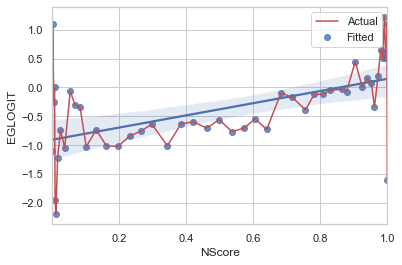

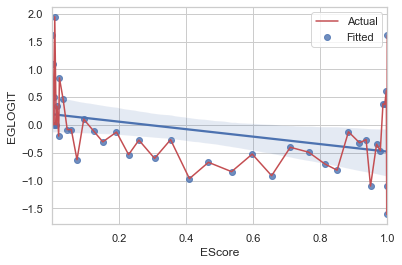

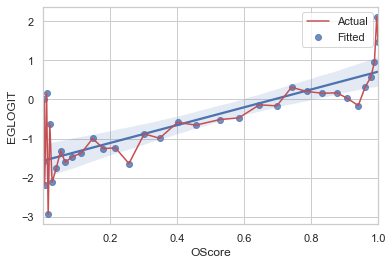

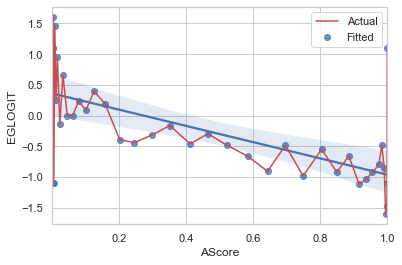

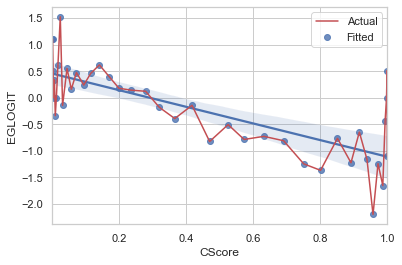

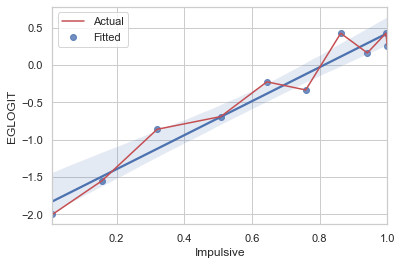

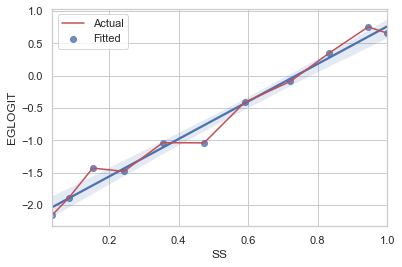

In [26]:
keys = list(emp.keys())
for i in keys:
    plt.figure()
    sns.regplot(rank_mean[i],emp[i],fit_reg=True,label="Fitted")
    sns.lineplot(rank_mean[i],emp[i],label="Actual",c="r")
    plt.xlabel(f"{i}")
    plt.ylabel("EGLOGIT")
    plt.show()

Assumptions for logistic regressions have been met and thus we will move forward with the modelling work 

#### Unbalanced Dataset

In [27]:
#Unbalanced dataset

x = df[["NScore","EScore","OScore","AScore","CScore","Impulsive","SS"]]
columns= x.columns
y = df[["monthly_u"]]

columns = train_x.columns

train_x,test_x,train_y,test_y = train_test_split(x,y,test_size=0.2,stratify=y,random_state=1250)

lr = LogisticRegression()
lr.fit(train_x,train_y)
predicted_class = lr.predict(test_x)

mcc = matthews_corrcoef(test_y,predicted_class)
acc = balanced_accuracy_score(test_y,predicted_class)
pre = precision_score(test_y,predicted_class,average="weighted")
rec = recall_score(test_y,predicted_class,average="weighted")
f1 = f1_score(test_y,predicted_class,average="weighted")
roc = roc = roc_auc_score(test_y,predicted_class)
print(f"MCC: {mcc}\nAccuracy: {acc}\nPrecision: {pre}\nRecall: {rec}\nF1: {f1}\nROC: {roc}")

lr.coef_.tolist()[0]
coef_dict = dict(zip(columns,lr.coef_.tolist()[0]))
print(f"coeffcients: {coef_dict}")
print(f"intercept:{lr.intercept_}")

#Score: Initial: 
#Accuracy: 0.645555357884125
#Precision: 0.6679413553653666
#Recall: 0.6737400530503979
#F1: 0.6694452362122076

MCC: 0.2988958701068617
Accuracy: 0.645555357884125
Precision: 0.6679413553653666
Recall: 0.6737400530503979
F1: 0.6694452362122076
ROC: 0.645555357884125
coeffcients: {'Age': 0.05180599285437647, 'Gender': -0.2154065314109383, 'Education': 0.4846723977267717, 'Country': -0.18025374578701125, 'Ethnicity': -0.3392805201226418, 'NScore': 0.06320093484495712, 'EScore': 0.7399922642816616}
intercept:[-0.59117305]


#### Balanced Dataset

In [90]:
from sklearn.preprocessing import scale

#Balanced Dataset:
cat_id = [5,6]
os = SMOTENC(categorical_features=cat_id,random_state=1250,sampling_strategy=1)
#os = SMOTE(random_state=1250)
x = df[["NScore","EScore","OScore","AScore","CScore","Impulsive","SS"]]
columns= x.columns
x = scale(x)
x = pd.DataFrame(x,columns=columns)

y = df[["monthly_u"]]
os_data_x, os_data_y = os.fit_sample(x,y)
os_data_X = pd.DataFrame(os_data_x,columns=columns)
os_data_Y = pd.DataFrame(os_data_y, columns=["monthly_u"])

train_x,test_x,train_y,test_y = train_test_split(os_data_X,os_data_Y,test_size=0.2,random_state=1250,stratify=os_data_Y)

lr = LogisticRegression()
lr.fit(train_x,train_y)
predicted_class = lr.predict(test_x)

mcc = matthews_corrcoef(test_y,predicted_class)
acc = accuracy_score(test_y,predicted_class)
pre = precision_score(test_y,predicted_class)
rec = recall_score(test_y,predicted_class)
f1 = f1_score(test_y,predicted_class)
roc = roc = roc_auc_score(test_y,predicted_class)
print(f"MCC: {mcc}\nAccuracy: {acc}\nPrecision: {pre}\nRecall: {rec}\nF1: {f1}\nROC: {roc}")


coef_dict = dict(zip(columns,lr.coef_.tolist()[0]))
print(f"coeffcients: {coef_dict}")
print(f"intercept:{lr.intercept_}")

month_coeff = lr.coef_.tolist()[0]



#Score:
#Accuracy: 0.7041036717062635
#Precision: 0.6862745098039216
#Recall: 0.7543103448275862
#F1: 0.7186858316221766

##Score I and SS treated as cat:
#Accuracy: 0.7170626349892009
#Precision: 0.6920152091254753
#Recall: 0.7844827586206896
#F1: 0.7353535353535354
#ROC: 0.7169167039856694

print(np.mean(biserial))

MCC: 0.4379052004145064
Accuracy: 0.7170626349892009
Precision: 0.6920152091254753
Recall: 0.7844827586206896
F1: 0.7353535353535354
ROC: 0.7169167039856694
coeffcients: {'NScore': 0.04291551885348663, 'EScore': -0.3141303050116849, 'OScore': 0.4681846203386, 'AScore': -0.162656642361819, 'CScore': -0.30904309087307263, 'Impulsive': 0.0410298337205088, 'SS': 0.891728802298476}
intercept:[-0.16780963]
0.0984534856865438


#### Balanced Dataset Cross Validation

In [30]:
#Model Cross Validation
x = df[["NScore","EScore","OScore","AScore","CScore","Impulsive","SS"]]
columns= x.columns
y = df[["monthly_u"]]

folds = StratifiedKFold(n_splits=10,random_state=1250)
cat_id = [5,6]
os = SMOTENC(categorical_features=cat_id,random_state=1250,sampling_strategy=1)
#os = SMOTE(random_state=1250)
os_data_x, os_data_y = os.fit_sample(x,y)
os_data_X = pd.DataFrame(os_data_x,columns=columns)
os_data_Y = pd.DataFrame(os_data_y, columns=["monthly_u"])

def get_score(model, train_x, test_x, train_y, test_y):
    model.fit(train_x, train_y)
    pred = model.predict(test_x)
    return [accuracy_score(test_y,pred),precision_score(test_y,pred),recall_score(test_y,pred),f1_score(test_y,pred), roc_auc_score(test_y,pred)]

acc = []
prec = []
rec = []
f1 = []
roc = []

for train_index,test_index in folds.split(os_data_X,os_data_Y):
    x_train,x_test = os_data_X.iloc[train_index],os_data_X.iloc[test_index],
    y_train, y_test = os_data_Y.iloc[train_index],os_data_Y.iloc[test_index]
    score = get_score(LogisticRegression(),x_train,x_test,y_train,y_test)
    acc.append(score[0])
    prec.append(score[1])
    rec.append(score[2])
    f1.append(score[3])
    roc.append(score[4])
    
print(f"Accuracy: {np.mean(acc)}\nPrecision: {np.mean(prec)}\nRecall: {np.mean(rec)}\nF1: {np.mean(f1)}\nROC: {np.mean(roc)}")

#Score:
#Accuracy: 0.7201466636811464
#Precision: 0.7185516670444431
#Recall: 0.7388905547226386
#F1: 0.725751562895317

#Score [Cat]:
#Accuracy: 0.72923197492163
#Precision: 0.7257328104527361
#Recall: 0.7519640179910045
#F1: 0.7353459763494858


Accuracy: 0.72923197492163
Precision: 0.7257328104527361
Recall: 0.7519640179910045
F1: 0.7353459763494858
ROC: 0.7293215892053972


#### Graphing Pscyhological Profile differences between users

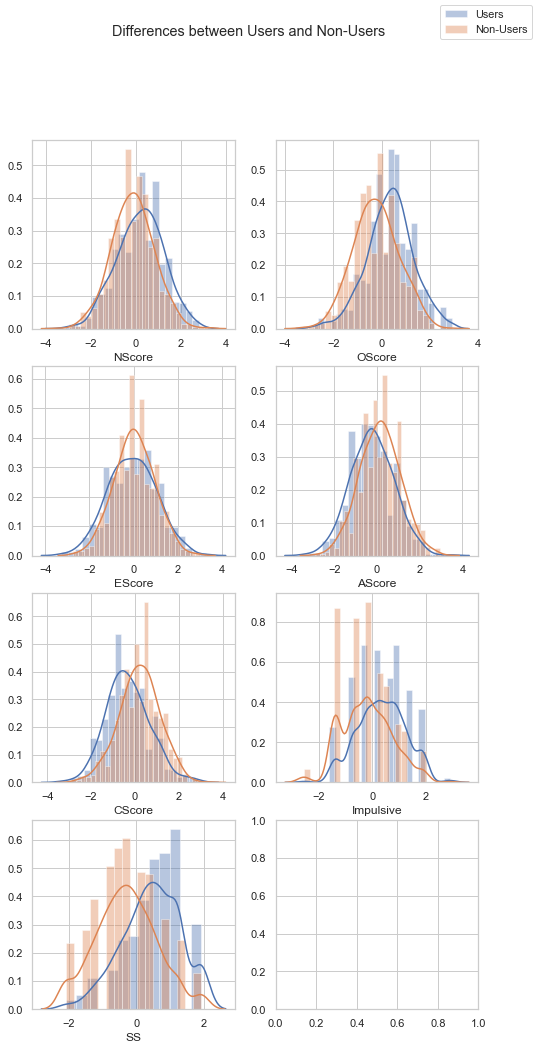

In [29]:
user = df[df["monthly_u"]==1]
non = df[df["monthly_u"]==0]
fig,ax = plt.subplots(4,2,figsize=(8,16))
sns.distplot(user["NScore"],ax=ax[0,0],label="Users")
sns.distplot(non["NScore"],ax=ax[0,0],label="Non-Users")
sns.distplot(user["OScore"],ax=ax[0,1],label="Users")
sns.distplot(non["OScore"],ax=ax[0,1],label="Non-Users")
sns.distplot(user["EScore"],ax=ax[1,0],label="Users")
sns.distplot(non["EScore"],ax=ax[1,0],label="Non-Users")
sns.distplot(user["AScore"],ax=ax[1,1],label="Users")
sns.distplot(non["AScore"],ax=ax[1,1],label="Non-Users")
sns.distplot(user["CScore"],ax=ax[2,0],label="Users")
sns.distplot(non["CScore"],ax=ax[2,0],label="Non-Users")
sns.distplot(user["Impulsive"],ax=ax[2,1],label="Users")
sns.distplot(non["Impulsive"],ax=ax[2,1],label="Non-Users")
sns.distplot(user["SS"],ax=ax[3,0],label="Users")
sns.distplot(non["SS"],ax=ax[3,0],label="Non-Users")
fig.legend(labels=["Users","Non-Users"],)
fig.suptitle("Differences between Users and Non-Users")
plt.show()

## What are the differences in psychological profile between monthly, weekly users and daily users
* Run 3 Logistic Regression Models(with CV scores) and compare coefficient values# between categories
* Line plot and analyse

### Weekly Users

In [67]:
x = df[["NScore","EScore","OScore","AScore","CScore","Impulsive","SS"]]
cat_id = [5,6]
columns= x.columns
x = scale(x)
x = pd.DataFrame(x, columns=columns)
y = df[["weekly_u"]]

columns = x.columns

os = SMOTENC(categorical_features=cat_id,random_state=1250,sampling_strategy=1)
#os = SMOTE(random_state=1250)
os_data_x, os_data_y = os.fit_sample(x,y)
os_data_X = pd.DataFrame(os_data_x,columns=columns)
os_data_Y = pd.DataFrame(os_data_y, columns=["weekly_u"])

train_x,test_x,train_y,test_y = train_test_split(os_data_X,os_data_Y,test_size=0.2,random_state=1250)

lr = LogisticRegression()
lr.fit(train_x,train_y)
predicted_class = lr.predict(test_x)

mcc = matthews_corrcoef(test_y,predicted_class)
acc = accuracy_score(test_y,predicted_class)
pre = precision_score(test_y,predicted_class)
rec = recall_score(test_y,predicted_class)
f1 = f1_score(test_y,predicted_class)
roc = roc_auc_score(test_y,predicted_class)
print(f"MCC: {mcc}\nAccuracy: {acc}\nPrecision: {pre}\nRecall: {rec}\nF1: {f1}\nROC: {roc}")

lr.coef_.tolist()[0]
coef_dict = dict(zip(columns,lr.coef_.tolist()[0]))
print(f"coeffcients: {coef_dict}")
print(f"intercept:{lr.intercept_}")

weekly_coeff = lr.coef_.tolist()[0]

## Score:
#Accuracy: 0.6774193548387096
#Precision: 0.6790540540540541
#Recall: 0.7027972027972028
#F1: 0.6907216494845361

## Score[SS and I as cat]:
#Accuracy: 0.6971326164874552
#Precision: 0.693069306930693
#Recall: 0.7342657342657343
#F1: 0.7130730050933786
print(roc_auc_score(test_y,predicted_class)) # 0.7130730050933786

# MCC: 0.3901244936309359
# Accuracy: 0.6953405017921147
# Precision: 0.6907894736842105
# Recall: 0.7342657342657343
# F1: 0.711864406779661
# ROC: 0.6943387494858082
# coeffcients: {'NScore': 0.15924316767846158, 'EScore': -0.20079319401459667, 'OScore': 0.29488814805843955, 'AScore': -0.10129588428747893, 'CScore': -0.26698251487940483, 'Impulsive': 0.3064229302946434, 'SS': 0.6604657387545014}
# intercept:[-0.32424017]

MCC: 0.3901244936309359
Accuracy: 0.6953405017921147
Precision: 0.6907894736842105
Recall: 0.7342657342657343
F1: 0.711864406779661
ROC: 0.6943387494858082
coeffcients: {'NScore': 0.15924316767846158, 'EScore': -0.20079319401459667, 'OScore': 0.29488814805843955, 'AScore': -0.10129588428747893, 'CScore': -0.26698251487940483, 'Impulsive': 0.3064229302946434, 'SS': 0.6604657387545014}
intercept:[-0.32424017]
0.6943387494858082


#### Weekly K-Fold Cross Val

In [69]:
x = df[["NScore","EScore","OScore","AScore","CScore","Impulsive","SS"]]
cat_id = [5,6]
columns= x.columns
x = scale(x)
x = pd.DataFrame(x, columns=columns)
y = df[["weekly_u"]]

columns = x.columns

os = SMOTENC(categorical_features=cat_id,random_state=1250,sampling_strategy=1)
#os = SMOTE(random_state=1250)
os_data_x, os_data_y = os.fit_sample(x,y)
os_data_X = pd.DataFrame(os_data_x,columns=columns)
os_data_Y = pd.DataFrame(os_data_y, columns=["weekly_u"])

os_data_Y = pd.DataFrame(os_data_y, columns=["weekly_u"])


acc = []
prec = []
rec = []
f1 = []
roc = []
for train_index,test_index in folds.split(os_data_X,os_data_Y):
    x_train,x_test = os_data_X.iloc[train_index],os_data_X.iloc[test_index],
    y_train, y_test = os_data_Y.iloc[train_index],os_data_Y.iloc[test_index]
    score = get_score(LogisticRegression(),x_train,x_test,y_train,y_test)
    acc.append(score[0])
    prec.append(score[1])
    rec.append(score[2])
    f1.append(score[3])
    roc.append(score[4])
    

print(f"Accuracy: {np.mean(acc)}\nPrecision: {np.mean(prec)}\nRecall: {np.mean(rec)}\nF1: {np.mean(f1)}\nROC: {np.mean(roc)}")

##Score(No Cat):
#Accuracy: 0.6951303473350351
#Precision: 0.6945806770766482
#Recall: 0.7194964028776979
#F1: 0.7041618306852275

#SS and I as Cat:
#Accuracy: 0.7094840256826797
#Precision: 0.7085410040062828
#Recall: 0.7373586844809866
#F1: 0.7178867084649017

#Scaled:
# Accuracy: 0.7091256027436116
# Precision: 0.707930482333009
# Recall: 0.7373484069886947
# F1: 0.7175850155588303
# ROC: 0.7089260020554985

Accuracy: 0.7091256027436116
Precision: 0.707930482333009
Recall: 0.7373484069886947
F1: 0.7175850155588303
ROC: 0.7089260020554985


### Daily Usesr

In [70]:
x = df[["NScore","EScore","OScore","AScore","CScore","Impulsive","SS"]]
y = df[["daily_u"]]
columns= x.columns
x = scale(x)
x = pd.DataFrame(x, columns=columns)

cat_id = [5,6]
os = SMOTENC(categorical_features=cat_id,random_state=1250,sampling_strategy=1)
#os = SMOTE(random_state=1250)
os_data_x, os_data_y = os.fit_sample(x,y)
os_data_X = pd.DataFrame(os_data_x,columns=columns)
os_data_Y = pd.DataFrame(os_data_y, columns=["daily_u"])

train_x,test_x,train_y,test_y = train_test_split(os_data_X,os_data_Y,test_size=0.2,random_state=1250)

lr = LogisticRegression()
lr.fit(train_x,train_y)
predicted_class = lr.predict(test_x)

mcc = matthews_corrcoef(test_y,predicted_class)
acc = accuracy_score(test_y,predicted_class)
pre = precision_score(test_y,predicted_class)
rec = recall_score(test_y,predicted_class)
f1 = f1_score(test_y,predicted_class)
roc = roc_auc_score(test_y,predicted_class)
print(f"MCC: {mcc}\nAccuracy: {acc}\nPrecision: {pre}\nRecall: {rec}\nF1: {f1}\nROC: {roc}")


coef_dict = dict(zip(columns,lr.coef_.tolist()[0]))
print(f"coeffcients: {coef_dict}")
print(f"intercept:{lr.intercept_}")

daily_coeff = lr.coef_.tolist()[0]

#Score:
#Accuracy: 0.6712962962962963
#Precision: 0.6715976331360947
#Recall: 0.6899696048632219
#F1: 0.6806596701649175
print(roc_auc_score(test_y,predicted_class)) # 0.6710036112090404

MCC: 0.34228618497514424
Accuracy: 0.6712962962962963
Precision: 0.6715976331360947
Recall: 0.6899696048632219
F1: 0.6806596701649175
ROC: 0.6710036112090404
coeffcients: {'NScore': 0.26348667472998233, 'EScore': -0.3468692969782991, 'OScore': 0.1387473514546404, 'AScore': -0.14671419627825846, 'CScore': 0.004419620663935169, 'Impulsive': 0.3678227233661185, 'SS': 0.4568222631176528}
intercept:[-0.30195991]
0.6710036112090404


#### Daily K-Fold

In [71]:
x = df[["NScore","EScore","OScore","AScore","CScore","Impulsive","SS"]]
cat_id = [5,6]
columns= x.columns
y = df[["daily_u"]]
columns = x.columns
x = scale(x)
x = pd.DataFrame(x, columns=columns)

os = SMOTENC(categorical_features=cat_id,random_state=1250,sampling_strategy=1)
os_data_x, os_data_y = os.fit_sample(x,y)
os_data_X = pd.DataFrame(os_data_x,columns=columns)
os_data_Y = pd.DataFrame(os_data_y, columns=["daily_u"])



acc = []
prec = []
rec = []
f1 = []
roc = []

for train_index,test_index in folds.split(os_data_X,os_data_Y):
    x_train,x_test = os_data_X.iloc[train_index],os_data_X.iloc[test_index],
    y_train, y_test = os_data_Y.iloc[train_index],os_data_Y.iloc[test_index]
    score = get_score(LogisticRegression(),x_train,x_test,y_train,y_test)
    acc.append(score[0])
    prec.append(score[1])
    rec.append(score[2])
    f1.append(score[3])
    roc.append(score[4])

print(f"Accuracy: {np.mean(acc)}\nPrecision: {np.mean(prec)}\nRecall: {np.mean(rec)}\nF1: {np.mean(f1)}\nROC: {np.mean(roc)}")

#Score:
#Accuracy: 0.6807667316439245
#Precision: 0.6803179184331801
#Recall: 0.7064412238325282
#F1: 0.6891237087198011

Accuracy: 0.6807667316439245
Precision: 0.6803179184331801
Recall: 0.7064412238325282
F1: 0.6891237087198011
ROC: 0.6807894333256652


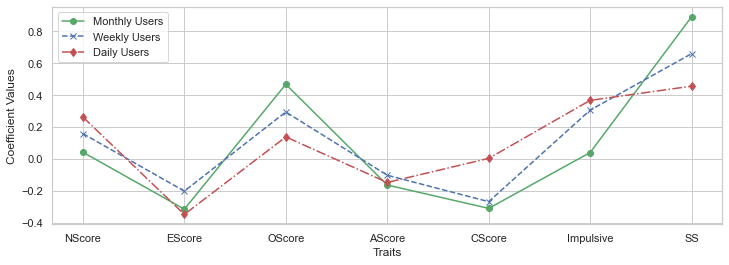

Monthly: {'NScore': 0.04291551885348663, 'EScore': -0.3141303050116849, 'OScore': 0.4681846203386, 'AScore': -0.162656642361819, 'CScore': -0.30904309087307263, 'Impulsive': 0.0410298337205088, 'SS': 0.891728802298476}

Weekly: {'NScore': 0.15924316767846158, 'EScore': -0.20079319401459667, 'OScore': 0.29488814805843955, 'AScore': -0.10129588428747893, 'CScore': -0.26698251487940483, 'Impulsive': 0.3064229302946434, 'SS': 0.6604657387545014}

Daily: {'NScore': 0.26348667472998233, 'EScore': -0.3468692969782991, 'OScore': 0.1387473514546404, 'AScore': -0.14671419627825846, 'CScore': 0.004419620663935169, 'Impulsive': 0.3678227233661185, 'SS': 0.4568222631176528}



In [95]:
fig,ax = plt.subplots(figsize=(12,4))
ax.plot(columns,month_coeff,marker="o",color="g",linestyle="-", label="Monthly Users")
ax.plot(columns,weekly_coeff,marker="x",color="b",linestyle="--", label="Weekly Users")
ax.plot(columns,daily_coeff,marker="d",color="r",linestyle="-.", label="Daily Users")
plt.ylabel("Coefficient Values")
plt.xlabel("Traits")
plt.legend()
plt.show()

print(f"Monthly: {dict(zip(columns,month_coeff))}\n")
print(f"Weekly: {dict(zip(columns,weekly_coeff))}\n")
print(f"Daily: {dict(zip(columns,daily_coeff))}\n")

Degree of Oscore and SS decreases as frequency increases
Degree of N,C,I increase as frequecy increases


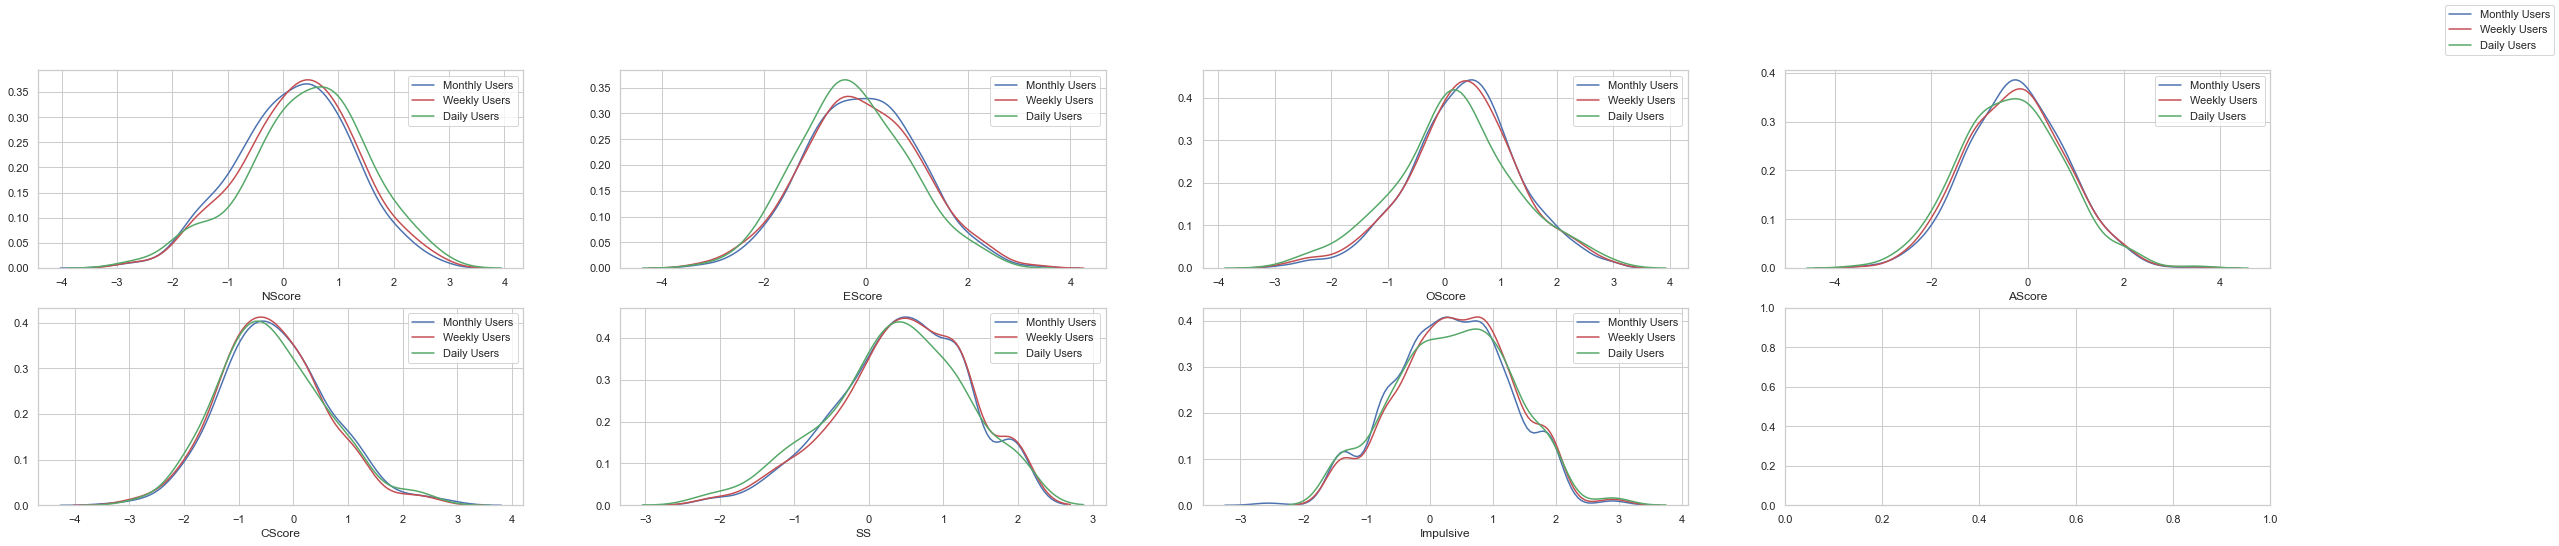

In [73]:
month = df[df["monthly_u"]==1]
week = df[df["weekly_u"]==1]
day = df[df["daily_u"]==1]
fig,ax = plt.subplots(2,4,figsize=(40,8))
sns.distplot(month["NScore"],ax=ax[0,0],label="Monthly Users",hist=False)
sns.distplot(week["NScore"],ax=ax[0,0],label="Weekly Users",hist=False,color="r")
sns.distplot(day["NScore"],ax=ax[0,0],label="Daily Users",hist=False,color="g")
sns.distplot(month["EScore"],ax=ax[0,1],label="Monthly Users",hist=False)
sns.distplot(week["EScore"],ax=ax[0,1],label="Weekly Users",hist=False,color="r")
sns.distplot(day["EScore"],ax=ax[0,1],label="Daily Users",hist=False,color="g")
sns.distplot(month["OScore"],ax=ax[0,2],label="Monthly Users",hist=False)
sns.distplot(week["OScore"],ax=ax[0,2],label="Weekly Users",hist=False,color="r")
sns.distplot(day["OScore"],ax=ax[0,2],label="Daily Users",hist=False,color="g")
sns.distplot(month["AScore"],ax=ax[0,3],label="Monthly Users",hist=False)
sns.distplot(week["AScore"],ax=ax[0,3],label="Weekly Users",hist=False,color="r")
sns.distplot(day["AScore"],ax=ax[0,3],label="Daily Users",hist=False,color="g")
sns.distplot(month["CScore"],ax=ax[1,0],label="Monthly Users",hist=False)
sns.distplot(week["CScore"],ax=ax[1,0],label="Weekly Users",hist=False,color="r")
sns.distplot(day["CScore"],ax=ax[1,0],label="Daily Users",hist=False,color="g")
sns.distplot(month["SS"],ax=ax[1,1],label="Monthly Users",hist=False)
sns.distplot(week["SS"],ax=ax[1,1],label="Weekly Users",hist=False,color="r")
sns.distplot(day["SS"],ax=ax[1,1],label="Daily Users",hist=False,color="g")
sns.distplot(month["Impulsive"],ax=ax[1,2],label="Monthly Users",hist=False)
sns.distplot(week["Impulsive"],ax=ax[1,2],label="Weekly Users",hist=False,color="r")
sns.distplot(day["Impulsive"],ax=ax[1,2],label="Daily Users",hist=False,color="g")
fig.legend(labels=["Monthly Users","Weekly Users","Daily Users"])
plt.show()

## Use another graph for better visualisation

## How do psychological profiles differ between users of different drug classes?
* 3 Models comparing coefficients between users of depressants, stimulants and hallucinogens 
* Validate models 
* Compare Coefficients and graph maybe using different type of graph ??

### Depressants

In [75]:
x = df[["NScore","EScore","OScore","AScore","CScore","Impulsive","SS"]]
cat_id = [0,1,2]
columns= x.columns
y = df[["Depress"]]
columns = x.columns
x = scale(x)
x = pd.DataFrame(x, columns=columns)

cat_id = [5,6]
os = SMOTENC(categorical_features=cat_id,random_state=1250,sampling_strategy=1)
#os = SMOTE(random_state=1250)
os_data_x, os_data_y = os.fit_sample(x,y)
os_data_X = pd.DataFrame(os_data_x,columns=columns)
os_data_Y = pd.DataFrame(os_data_y, columns=["Depress"])

train_x,test_x,train_y,test_y = train_test_split(os_data_X,os_data_Y,test_size=0.2,random_state=1250)

lr = LogisticRegression()
lr.fit(train_x,train_y)
predicted_class = lr.predict(test_x)

mcc = matthews_corrcoef(test_y,predicted_class)
acc = accuracy_score(test_y,predicted_class)
pre = precision_score(test_y,predicted_class)
rec = recall_score(test_y,predicted_class)
f1 = f1_score(test_y,predicted_class)
roc = roc_auc_score(test_y,predicted_class)
print(f"MCC: {mcc}\nAccuracy: {acc}\nPrecision: {pre}\nRecall: {rec}\nF1: {f1}\nROC: {roc}")


coef_dict = dict(zip(columns,lr.coef_.tolist()[0]))
print(f"coeffcients: {coef_dict}")
print(f"intercept:{lr.intercept_}")

depress_coeff = lr.coef_.tolist()[0]

#Score
#Accuracy: 0.6550724637681159
#Precision: 0.6467391304347826
#Recall: 0.6878612716763006
#F1: 0.6666666666666667


MCC: 0.3164541331923687
Accuracy: 0.6579710144927536
Precision: 0.6494565217391305
Recall: 0.6907514450867052
F1: 0.6694677871148459
ROC: 0.6578757225433526
coeffcients: {'NScore': 0.3327354692392369, 'EScore': -0.37702758527075386, 'OScore': 0.07221546432426149, 'AScore': -0.05042612606285059, 'CScore': 0.13189763656691847, 'Impulsive': 0.031084615684339345, 'SS': 0.48377416580703}
intercept:[-0.19326944]


In [76]:
## Depress Model Kfold Cross Validation

x = df[["NScore","EScore","OScore","AScore","CScore","Impulsive","SS"]]
cat_id = [5,6]
columns= x.columns
x = scale(x)
x = pd.DataFrame(x, columns=columns)
y = df[["Depress"]]

columns = x.columns

os = SMOTENC(categorical_features=cat_id,random_state=1250,sampling_strategy=1)
#os = SMOTE(random_state=1250)
os_data_x, os_data_y = os.fit_sample(x,y)
os_data_X = pd.DataFrame(os_data_x,columns=columns)
os_data_Y = pd.DataFrame(os_data_y, columns=["Depress"])



acc = []
prec = []
rec = []
f1 = []
roc = []

for train_index,test_index in folds.split(os_data_X,os_data_Y):
    x_train,x_test = os_data_X.iloc[train_index],os_data_X.iloc[test_index],
    y_train, y_test = os_data_Y.iloc[train_index],os_data_Y.iloc[test_index]
    score = get_score(LogisticRegression(),x_train,x_test,y_train,y_test)
    acc.append(score[0])
    prec.append(score[1])
    rec.append(score[2])
    f1.append(score[3])
    roc.append(score[4])

    


print(f"Accuracy: {np.mean(acc)}\nPrecision: {np.mean(prec)}\nRecall: {np.mean(rec)}\nF1: {np.mean(f1)}\nROC: {np.mean(roc)}")


#Score:
#Accuracy: 0.6561198179979778
#Precision: 0.6523599758971879
#Recall: 0.6901095577362549
#F1: 0.6681006830734814


Accuracy: 0.6555384226491405
Precision: 0.6516704720630196
Recall: 0.6895281623874177
F1: 0.6674631036091333
ROC: 0.6554661244790967


### Stimulants

In [77]:
x = df[["NScore","EScore","OScore","AScore","CScore","Impulsive","SS"]]
cat_id = [5,6]
columns= x.columns
x = scale(x)
x = pd.DataFrame(x, columns=columns)
y = df[["Stim"]]

columns = x.columns

os = SMOTENC(categorical_features=cat_id,random_state=1250,sampling_strategy=1)
#os = SMOTE(random_state=1250)
os_data_x, os_data_y = os.fit_sample(x,y)
os_data_X = pd.DataFrame(os_data_x,columns=columns)
os_data_Y = pd.DataFrame(os_data_y, columns=["Stim"])

train_x,test_x,train_y,test_y = train_test_split(os_data_X,os_data_Y,test_size=0.2,random_state=1250)

lr = LogisticRegression()
lr.fit(train_x,train_y)
predicted_class = lr.predict(test_x)

mcc = matthews_corrcoef(test_y,predicted_class)
acc = accuracy_score(test_y,predicted_class)
pre = precision_score(test_y,predicted_class)
rec = recall_score(test_y,predicted_class)
f1 = f1_score(test_y,predicted_class)
roc = roc_auc_score(test_y,predicted_class)
print(f"MCC: {mcc}\nAccuracy: {acc}\nPrecision: {pre}\nRecall: {rec}\nF1: {f1}\nROC: {roc}")


coef_dict = dict(zip(columns,lr.coef_.tolist()[0]))
print(f"coeffcients: {coef_dict}")
print(f"intercept:{lr.intercept_}")

stim_coeff = lr.coef_.tolist()[0]
#Score
#Accuracy: 0.6820143884892086
#Precision: 0.6892655367231638
#Recall: 0.6873239436619718
#F1: 0.6882933709449929
print(roc_auc_score(test_y,predicted_class)) # 0.6818972659486331

MCC: 0.36661143330571666
Accuracy: 0.6834532374100719
Precision: 0.6901408450704225
Recall: 0.6901408450704225
F1: 0.6901408450704225
ROC: 0.6833057166528584
coeffcients: {'NScore': -0.2708000549496776, 'EScore': -0.060198526473568804, 'OScore': 0.06519942879015209, 'AScore': -0.041077292272972535, 'CScore': -0.24065976818911866, 'Impulsive': 0.17027739857801022, 'SS': 0.5278575647463924}
intercept:[-0.226028]
0.6833057166528584


In [78]:
## Stimulants Model Kfold Cross Validation

x = df[["NScore","EScore","OScore","AScore","CScore","Impulsive","SS"]]
cat_id = [5,6]
columns= x.columns
x = scale(x)
x = pd.DataFrame(x, columns=columns)
y = df[["Stim"]]

columns = x.columns

os = SMOTENC(categorical_features=cat_id,random_state=1250,sampling_strategy=1)
#os = SMOTE(random_state=1250)
os_data_x, os_data_y = os.fit_sample(x,y)
os_data_X = pd.DataFrame(os_data_x,columns=columns)
os_data_Y = pd.DataFrame(os_data_y, columns=["Stim"])



acc = []
prec = []
rec = []
f1 = []
roc = []

for train_index,test_index in folds.split(os_data_X,os_data_Y):
    x_train,x_test = os_data_X.iloc[train_index],os_data_X.iloc[test_index],
    y_train, y_test = os_data_Y.iloc[train_index],os_data_Y.iloc[test_index]
    score = get_score(LogisticRegression(),x_train,x_test,y_train,y_test)
    acc.append(score[0])
    prec.append(score[1])
    rec.append(score[2])
    f1.append(score[3])
    roc.append(score[4])

    


print(f"Accuracy: {np.mean(acc)}\nPrecision: {np.mean(prec)}\nRecall: {np.mean(rec)}\nF1: {np.mean(f1)}\nROC: {roc}")

#Score:
#Accuracy: 0.6405081321010965
#Precision: 0.643638604333303
#Recall: 0.6710882997807455
#F1: 0.6536424165318095


Accuracy: 0.6405081321010965
Precision: 0.643638604333303
Recall: 0.6710882997807455
F1: 0.6536424165318095
ROC: [0.7097701149425287, 0.7270114942528736, 0.7032921400571391, 0.6396584944521957, 0.5269417314464154, 0.6077669257856622, 0.5824197727725733, 0.6254069497043386, 0.6973955218922331, 0.5852767257989503]


### Hallucinogenics

In [79]:
x = df[["NScore","EScore","OScore","AScore","CScore","Impulsive","SS"]]
columns= x.columns
y = df[["Hallu"]]
x = scale(x)
x = pd.DataFrame(x, columns=columns)

cat_id = [5,6]
os = SMOTENC(categorical_features=cat_id,random_state=1250,sampling_strategy=1)
#os = SMOTE(random_state=1250)
os_data_x, os_data_y = os.fit_sample(x,y)
os_data_X = pd.DataFrame(os_data_x,columns=columns)
os_data_Y = pd.DataFrame(os_data_y, columns=["Hallu"])

train_x,test_x,train_y,test_y = train_test_split(os_data_X,os_data_Y,test_size=0.2,random_state=1250)

lr = LogisticRegression()
lr.fit(train_x,train_y)
predicted_class = lr.predict(test_x)

mcc = matthews_corrcoef(test_y,predicted_class)
acc = accuracy_score(test_y,predicted_class)
pre = precision_score(test_y,predicted_class)
rec = recall_score(test_y,predicted_class)
f1 = f1_score(test_y,predicted_class)
roc = roc_auc_score(test_y,predicted_class)
print(f"MCC: {mcc}\nAccuracy: {acc}\nPrecision: {pre}\nRecall: {rec}\nF1: {f1}\nROC: {roc}")


coef_dict = dict(zip(columns,lr.coef_.tolist()[0]))
print(f"coeffcients: {coef_dict}")
print(f"intercept:{lr.intercept_}")

hallu_coef = lr.coef_.tolist()[0]

#Score:
#Accuracy: 0.7182705718270572
#Precision: 0.7214484679665738
#Recall: 0.7174515235457064
#F1: 0.7194444444444444
#ROC: 0.718276323570606

MCC: 0.43654245687630017
Accuracy: 0.7182705718270572
Precision: 0.7214484679665738
Recall: 0.7174515235457064
F1: 0.7194444444444444
ROC: 0.718276323570606
coeffcients: {'NScore': -0.31512267497958624, 'EScore': -0.4481965577010008, 'OScore': 0.6495677014910266, 'AScore': -0.013690553349928863, 'CScore': -0.4072110390283103, 'Impulsive': -0.2168330839938622, 'SS': 1.0118949396958055}
intercept:[-0.64889236]


In [80]:
#Hallu Kfold
x = df[["NScore","EScore","OScore","AScore","CScore","Impulsive","SS"]]
cat_id = [5,6]
y = df[["Hallu"]]

columns = x.columns
x = scale(x)
x = pd.DataFrame(x, columns=columns)


os = SMOTENC(categorical_features=cat_id,random_state=1250,sampling_strategy=1)
#os = SMOTE(random_state=1250)
os_data_x, os_data_y = os.fit_sample(x,y)
os_data_X = pd.DataFrame(os_data_x,columns=columns)
os_data_Y = pd.DataFrame(os_data_y, columns=["Hallu"])



acc = []
prec = []
rec = []
f1 = []
roc = []

for train_index,test_index in folds.split(os_data_X,os_data_Y):
    x_train,x_test = os_data_X.iloc[train_index],os_data_X.iloc[test_index],
    y_train, y_test = os_data_Y.iloc[train_index],os_data_Y.iloc[test_index]
    score = get_score(LogisticRegression(),x_train,x_test,y_train,y_test)
    acc.append(score[0])
    prec.append(score[1])
    rec.append(score[2])
    f1.append(score[3])
    roc.append(score[4])

    


print(f"Accuracy: {np.mean(acc)}\nPrecision: {np.mean(prec)}\nRecall: {np.mean(rec)}\nF1: {np.mean(f1)}\nROC: {np.mean(roc)}")

#Score:
#Accuracy: 0.7104464605281586
#Precision: 0.7088987033043725
#Recall: 0.7498634388578522
#F1: 0.7247432814721422



Accuracy: 0.7107257901370971
Precision: 0.7091925349536348
Recall: 0.7498634388578522
F1: 0.7249201127572857
ROC: 0.7107216014897579


### Analysis

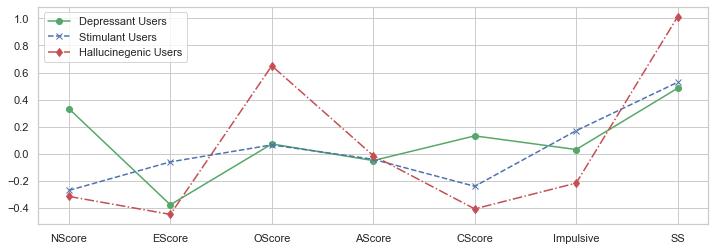

In [81]:
fig,ax = plt.subplots(figsize=(12,4))
ax.plot(columns,depress_coeff,marker="o",color="g",linestyle="-", label="Depressant Users")
ax.plot(columns,stim_coeff,marker="x",color="b",linestyle="--", label="Stimulant Users")
ax.plot(columns,hallu_coef,marker="d",color="r",linestyle="-.", label="Hallucinegenic Users")
plt.legend()
plt.show()

* Traits that determine drug preference: N,O,C,I,SS
* Depressants and Hallucinegenic users have the most different personality profiles, taking extremes, whereas stimulant users fall somewhere between the two
* CScore, Impulsive and SS good determinant on drug preference
* NScore and OScore, might be a good determinant if the user has a preference for stimulants/depressants or hallucinogens
    * If user falls within the stimulant depressant preference line, the factor that will determine if the user will like stimulants or not will be based on their degree of extraversion and and Concienciousness.

## Comparison between Users of Legal Drugs and Illegal Drug Users
'Alcohol','Amphet', 'Amyl', 'Benzos', 'Caff', 'Canab', 'Choc', 'Coke', 'Crack','Ecstasy', 'Heroin', 'Ket', 'LegalH', 'LSD', 'Meth', 'Mushroom','Nicotine', 'Semer', 'VSA', 'Depress', 'Stim', 'Hallu'

* Amphetamines, Benzodiazapines and Methadone are not considered in this analysis as these are drugs that could be prescribed,therefore hard to distinguish between necessities or drug abuse.

* Legal Drugs: Alcohol,Canab, Amyl,LegalH,Methadone,Nicotine 
* Illegal Coke,Crack,Ecstasy,Heroin,Ket,LSD
* Current problem hard to seperate all these drugs cleanly,

### Legal

In [82]:
x = df[["NScore","EScore","OScore","AScore","CScore","Impulsive","SS"]]
y = df[["Legal"]]

columns = x.columns
x = scale(x)
x = pd.DataFrame(x, columns=columns)

cat_id = [5,6]
os = SMOTENC(categorical_features=cat_id,random_state=1250,sampling_strategy=1)
#os = SMOTE(random_state=1250)
os_data_x, os_data_y = os.fit_sample(x,y)
os_data_X = pd.DataFrame(os_data_x,columns=columns)
os_data_Y = pd.DataFrame(os_data_y, columns=["Legal"])

train_x,test_x,train_y,test_y = train_test_split(os_data_X,os_data_Y,test_size=0.2,random_state=1250)

lr = LogisticRegression()
lr.fit(train_x,train_y)
predicted_class = lr.predict(test_x)

mcc = matthews_corrcoef(test_y,predicted_class)
acc = accuracy_score(test_y,predicted_class)
pre = precision_score(test_y,predicted_class)
rec = recall_score(test_y,predicted_class)
f1 = f1_score(test_y,predicted_class)
roc = roc_auc_score(test_y,predicted_class)
print(f"MCC: {mcc}\nAccuracy: {acc}\nPrecision: {pre}\nRecall: {rec}\nF1: {f1}\nROC: {roc}")


coef_dict = dict(zip(columns,lr.coef_.tolist()[0]))
print(f"coeffcients: {coef_dict}")
print(f"intercept:{lr.intercept_}")

legal_coef = lr.coef_.tolist()[0]
#Score:
#Accuracy: 0.6122840690978887
#Precision: 0.6275303643724697
#Recall: 0.5849056603773585
#F1: 0.6054687

MCC: 0.225800424031615
Accuracy: 0.6122840690978887
Precision: 0.6275303643724697
Recall: 0.5849056603773585
F1: 0.60546875
ROC: 0.6127653301886793
coeffcients: {'NScore': 0.06786721927555896, 'EScore': 0.08894416456471853, 'OScore': -0.26599128493305185, 'AScore': 0.19672240840571859, 'CScore': 0.1409677376013029, 'Impulsive': -0.08619561318233304, 'SS': -0.3940624386231525}
intercept:[0.07810296]


In [83]:
#Legal KF
x = df[["NScore","EScore","OScore","AScore","CScore","Impulsive","SS"]]
cat_id = [5,6]
y = df[["Legal"]]

columns = x.columns
x = scale(x)
x = pd.DataFrame(x, columns=columns)

os = SMOTENC(categorical_features=cat_id,random_state=1250,sampling_strategy=1)
#os = SMOTE(random_state=1250)
os_data_x, os_data_y = os.fit_sample(x,y)
os_data_X = pd.DataFrame(os_data_x,columns=columns)
os_data_Y = pd.DataFrame(os_data_y, columns=["Legal"])



acc = []
prec = []
rec = []
f1 = []
roc = []

for train_index,test_index in folds.split(os_data_X,os_data_Y):
    x_train,x_test = os_data_X.iloc[train_index],os_data_X.iloc[test_index],
    y_train, y_test = os_data_Y.iloc[train_index],os_data_Y.iloc[test_index]
    score = get_score(LogisticRegression(),x_train,x_test,y_train,y_test)
    acc.append(score[0])
    prec.append(score[1])
    rec.append(score[2])
    f1.append(score[3])
    roc.append(score[4])

    


print(f"Accuracy: {np.mean(acc)}\nPrecision: {np.mean(prec)}\nRecall: {np.mean(rec)}\nF1: {np.mean(f1)}\nROC: {np.mean(roc)}")

#Score:
#Accuracy: 0.6483097553787209
#Precision: 0.6579382148466323
#Recall: 0.6163065179095712
#F1: 0.6319555591326758

Accuracy: 0.6483097553787209
Precision: 0.6577689717346151
Recall: 0.6170757486788021
F1: 0.6322675617916156
ROC: 0.6483675866118614


### Illegal

In [84]:
x = df[["NScore","EScore","OScore","AScore","CScore","Impulsive","SS"]]
cat_id = [0,1,2]
y = df[["Illegal"]]

columns = x.columns
x = scale(x)
x = pd.DataFrame(x, columns=columns)

cat_id = [0,1,2,8]
#os = SMOTENC(categorical_features=cat_id,random_state=1250,sampling_strategy=1)
os = SMOTE(random_state=1250)
os_data_x, os_data_y = os.fit_sample(x,y)
os_data_X = pd.DataFrame(os_data_x,columns=columns)
os_data_Y = pd.DataFrame(os_data_y, columns=["Illegal"])

train_x,test_x,train_y,test_y = train_test_split(os_data_X,os_data_Y,test_size=0.2,random_state=1250)

lr = LogisticRegression()
lr.fit(train_x,train_y)
predicted_class = lr.predict(test_x)

mcc = matthews_corrcoef(test_y,predicted_class)
acc = accuracy_score(test_y,predicted_class)
pre = precision_score(test_y,predicted_class)
rec = recall_score(test_y,predicted_class)
f1 = f1_score(test_y,predicted_class)
roc = roc_auc_score(test_y,predicted_class)
print(f"MCC: {mcc}\nAccuracy: {acc}\nPrecision: {pre}\nRecall: {rec}\nF1: {f1}\nROC: {roc}")


coef_dict = dict(zip(columns,lr.coef_.tolist()[0]))
print(f"coeffcients: {coef_dict}")
print(f"intercept:{lr.intercept_}")

illegal_coef = lr.coef_.tolist()[0]

#Score:
#Accuracy: 0.7439446366782007
#Precision: 0.7222222222222222
#Recall: 0.778169014084507
#F1: 0.7491525423728812

MCC: 0.48652391202188455
Accuracy: 0.7422145328719724
Precision: 0.7198697068403909
Recall: 0.778169014084507
F1: 0.7478849407783418
ROC: 0.742826003640893
coeffcients: {'NScore': 0.005313053371897116, 'EScore': -0.06888790860271622, 'OScore': 0.5682363413039498, 'AScore': -0.26377227717588975, 'CScore': -0.31984901904575486, 'Impulsive': -0.039123019927300225, 'SS': 0.6533915625427178}
intercept:[-0.31159009]


In [49]:
#Illegal KF
x = df[["NScore","EScore","OScore","AScore","CScore","Impulsive","SS"]]
cat_id = [5,6]
columns= x.columns
y = df[["Illegal"]]

columns = x.columns

os = SMOTENC(categorical_features=cat_id,random_state=1250,sampling_strategy=1)
#os = SMOTE(random_state=1250)
os_data_x, os_data_y = os.fit_sample(x,y)
os_data_X = pd.DataFrame(os_data_x,columns=columns)
os_data_Y = pd.DataFrame(os_data_y, columns=["Illegal"])



acc = []
prec = []
rec = []
f1 = []
roc = []

for train_index,test_index in folds.split(os_data_X,os_data_Y):
    x_train,x_test = os_data_X.iloc[train_index],os_data_X.iloc[test_index],
    y_train, y_test = os_data_Y.iloc[train_index],os_data_Y.iloc[test_index]
    score = get_score(LogisticRegression(),x_train,x_test,y_train,y_test)
    acc.append(score[0])
    prec.append(score[1])
    rec.append(score[2])
    f1.append(score[3])
    roc.append(score[4])

    


print(f"Accuracy: {np.mean(acc)}\nPrecision: {np.mean(prec)}\nRecall: {np.mean(rec)}\nF1: {np.mean(f1)}\nROC: {np.mean(roc)}")

#Score:
#Accuracy: 0.7376802191464822
#Precision: 0.7347014030476211
#Recall: 0.7707710727969348
#F1: 0.7470664167286951


Accuracy: 0.7376802191464822
Precision: 0.7347014030476211
Recall: 0.7707710727969348
F1: 0.7470664167286951
ROC: 0.737852011494253


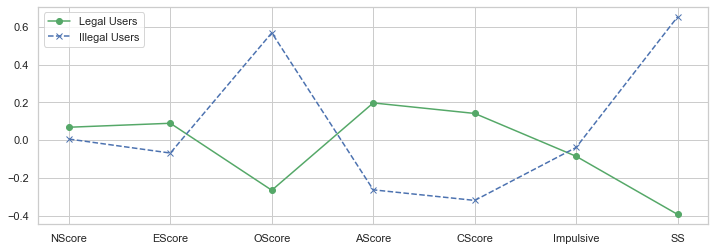

In [85]:
fig,ax = plt.subplots(figsize=(12,4))
ax.plot(columns,legal_coef,marker="o",color="g",linestyle="-", label="Legal Users")
ax.plot(columns,illegal_coef,marker="x",color="b",linestyle="--", label="Illegal Users")
plt.legend()

Risk taking behaviour seems to be dictated by OScore, AScore, CScore and SS
* Risk takers tend to have high openness and SS scores , Low levels of Agreeableness and Concienciousness

## Using K-Means Clustering To Cluster Users into their drug uses based on personality scores
* N,C,O,I,SS
* Try C and SS First 
* C and I
* I and SS

In [51]:
from sklearn.cluster import KMeans

### Label Users all users based on their highest drug used
* Create a dictionary containing all drugs and their frequency usage across each drug
    * Split CL5 string and extract last number
* Get max value of the dictionary and it's associated key, assign it as the new column

In [52]:
label = []
user = ["CL4","CL5","CL6"]
drug_class = {"Depress":["Benzos","Amyl","Heroin","Meth"],"Stim":["Amphet","Ecstasy","Coke","Crack"],"Hallu":["Ket","LSD","Mushroom"]}
count = 0
for am,amy,benz,co,cr,ec,he,k,ls,met,mush in zip(df["Amphet"],df["Amyl"],df["Benzos"],df["Coke"],df["Crack"],df["Ecstasy"],df["Heroin"],df["Ket"],df["LSD"],df["Meth"],df["Mushroom"]):
    if any([benz in user,he in user, met in user, amy in user,am in user, ec in user, co in user,cr in user,ls in user, mush in user, k in user]):
        comp = {}
        comp["Amphet"] = list(am)[2]
        comp["Amyl"] = list(amy)[2]
        comp["Benzos"] = list(benz)[2]
        comp["Coke"] = list(co)[2]
        comp["Crack"] = list(cr)[2]
        comp["Ecstasy"] = list(ec)[2]
        comp["Heroin"] = list(he)[2]
        comp["Ket"] = list(k)[2]
        comp["LSD"] = list(ls)[2]
        comp["Meth"] = list(met)[2]
        comp["Mushroom"] = list(mush)[2]
        comp = dict(sorted(comp.items(), key=lambda item: item[1]))
        v =  list(comp.values())
        k = list(comp.keys())
        if v[-1] == v[-2]:
            if all([k[-1] in drug_class["Depress"],k[-2] in drug_class["Depress"]]):
                label.append(1)
            elif all([k[-1] in drug_class["Stim"],k[-2] in drug_class["Stim"]]):
                label.append(2)
            elif all([k[-1] in drug_class["Hallu"],k[-2] in drug_class["Hallu"]]):
                label.append(3)
            else:
                label.append(4)
        else:
            if k[-1] in drug_class["Depress"]:
                label.append(1)
            elif k[-1] in drug_class["Stim"]:
                label.append(2)
            elif k[-1] in drug_class["Hallu"]:
                label.append(3)
    else:
        label.append(0)


#0: None
#1: Depress
#2: Stim
#3: Hallu
#4: Mix
df["Labels"] = label
df.head(30)

,Age,Gender,Education,Country,Ethnicity,NScore,EScore,OScore,AScore,CScore,...,VSA,Depress,Stim,Hallu,monthly_u,weekly_u,daily_u,Legal,Illegal,Labels
ID,,,,,,,,,,,,,,,,,,,,,
2.0,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,...,CL0,0,1,0,1,0,0,0,1,2
3.0,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,...,CL0,0,0,0,0,0,0,1,0,0
4.0,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,...,CL0,0,0,0,0,0,0,1,0,0
5.0,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,...,CL0,0,0,0,0,0,0,1,0,0
6.0,2.59171,0.48246,-1.22751,0.24923,-0.31685,-0.67825,-0.30033,-1.55521,2.03972,1.63088,...,CL0,0,0,0,0,0,0,1,0,0
7.0,1.09449,-0.48246,1.16365,-0.57009,-0.31685,-0.46725,-1.09207,-0.45174,-0.30172,0.93949,...,CL0,0,0,0,0,0,0,1,0,0
8.0,0.49788,-0.48246,-1.73790,0.96082,-0.31685,-1.32828,1.93886,-0.84732,-0.30172,1.63088,...,CL0,0,0,0,0,0,0,1,0,0
9.0,0.49788,0.48246,-0.05921,0.24923,-0.31685,0.62967,2.57309,-0.97631,0.76096,1.13407,...,CL0,0,0,0,0,0,0,1,0,0
10.0,1.82213,-0.48246,1.16365,0.96082,-0.31685,-0.24649,0.00332,-1.42424,0.59042,0.12331,...,CL0,0,0,0,0,0,0,1,0,0


### K-Means Clustering

In [53]:
profiles = df.iloc[:,0:12]
true_label = df.iloc[:,39].to_numpy()

#4 Cluster K-Means
k_model = KMeans(init="random",n_clusters=5)
k_model.fit_predict(profiles)
k_label  = k_model.labels_



In [54]:
# for i,cl_l in enumerate(k_label):
#     print(f"Cluster Label: {cl_l},True Label: {true_label[i]}")

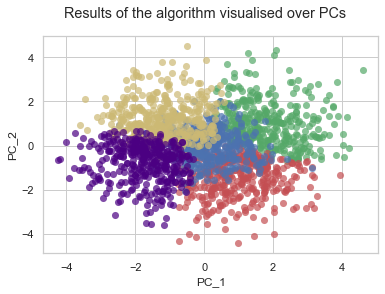

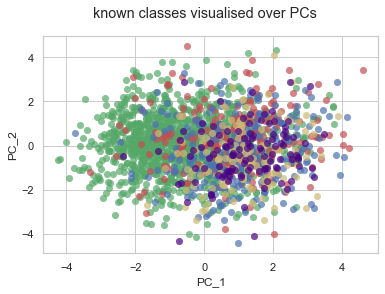

In [55]:
pca = PCA(n_components=2)

pca.fit(profiles)

projectedAx = pca.transform(profiles)
projectedAx = pd.DataFrame(projectedAx)
plt.figure(1)
plt.suptitle('Results of the algorithm visualised over PCs')
plt.xlabel('PC_1')
plt.ylabel('PC_2')
plt.scatter(projectedAx[k_label==0][0], projectedAx[k_label==0][1], c = "g", s = 50, alpha = 0.7, linewidth=0)
plt.scatter(projectedAx[k_label==1][0], projectedAx[k_label==1][1], c = "r", s = 50, alpha = 0.7, linewidth=0)
plt.scatter(projectedAx[k_label==2][0], projectedAx[k_label==2][1], c = "b", s = 50, alpha = 0.7, linewidth=0)
plt.scatter(projectedAx[k_label==3][0], projectedAx[k_label==3][1], c = "y", s = 50, alpha = 0.7, linewidth=0)
plt.scatter(projectedAx[k_label==4][0], projectedAx[k_label==4][1], c = "indigo", s = 50, alpha = 0.7, linewidth=0)

plt.show()

plt.figure(1)
plt.suptitle('known classes visualised over PCs')
plt.xlabel('PC_1')
plt.ylabel('PC_2')
plt.scatter(projectedAx[true_label==0][0], projectedAx[true_label==0][1], c = "g", s = 50, alpha = 0.7, linewidth=0)
plt.scatter(projectedAx[true_label==1][0], projectedAx[true_label==1][1], c = "r", s = 50, alpha = 0.7, linewidth=0)
plt.scatter(projectedAx[true_label==2][0], projectedAx[true_label==2][1], c = "b", s = 50, alpha = 0.7, linewidth=0)
plt.scatter(projectedAx[true_label==3][0], projectedAx[true_label==3][1], c = "y", s = 50, alpha = 0.7, linewidth=0)
plt.scatter(projectedAx[true_label==4][0], projectedAx[true_label==4][1], c = "indigo", s = 50, alpha = 0.7, linewidth=0)
plt.show()

## Attempt K-Means based on Usage

In [56]:
label = []
high = ["CL4","CL5","CL6"]
low = ["CL2","CL3"]
non = ["CL0","CL1"]

for am,amy,benz,co,cr,ec,he,k,ls,met,mush in zip(df["Amphet"],df["Amyl"],df["Benzos"],df["Coke"],df["Crack"],df["Ecstasy"],df["Heroin"],df["Ket"],df["LSD"],df["Meth"],df["Mushroom"]):
    if any([benz in high,he in high, met in high, amy in high,am in high, ec in high, co in high,cr in high,ls in high, mush in high, k in high]):
        label.append(2)
    elif any([benz in low,he in low, met in low, amy in low,am in low, ec in low, co in low,cr in low,ls in low, mush in low, k in low]):
        label.append(1)
    else:
        label.append(0)
df["Label"] = label
df["Label"].value_counts()


2    728
0    651
1    505
Name: Label, dtype: int64

In [57]:
profiles = df.iloc[:,0:12]
true_label = df.iloc[:,39].to_numpy()

#3 Cluster K-Means
k_model = KMeans(init="random",n_clusters=3)
k_model.fit_predict(profiles)
k_label  = k_model.labels_


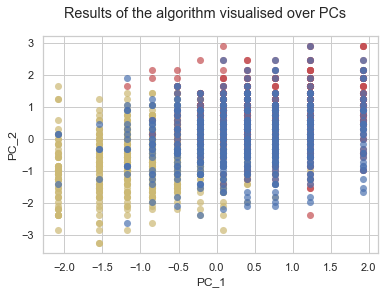

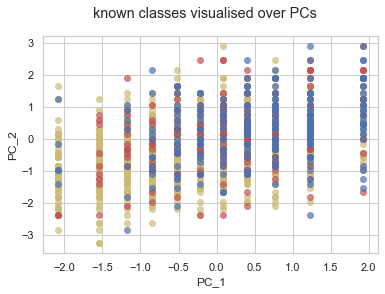

In [58]:
pca = PCA(n_components=2)

pca.fit(profiles)

projectedAx = pca.transform(profiles)
projectedAx = pd.DataFrame(projectedAx)
plt.figure(1)
plt.suptitle('Results of the algorithm visualised over PCs')
plt.xlabel('PC_1')
plt.ylabel('PC_2')
plt.scatter(profiles[k_label==0]["SS"], profiles[k_label==0]["OScore"], c = "y", s = 50, alpha = 0.7, linewidth=0)
plt.scatter(profiles[k_label==1]["SS"], profiles[k_label==1]["OScore"], c = "r", s = 50, alpha = 0.7, linewidth=0)
plt.scatter(profiles[k_label==2]["SS"], profiles[k_label==2]["OScore"], c = "b", s = 50, alpha = 0.7, linewidth=0)
plt.show()

plt.figure(1)
plt.suptitle('known classes visualised over PCs')
plt.xlabel('PC_1')
plt.ylabel('PC_2')
plt.scatter(profiles[true_label==0]["SS"], profiles[true_label==0]["OScore"], c = "y", s = 50, alpha = 0.7, linewidth=0)
plt.scatter(profiles[true_label==1]["SS"], profiles[true_label==1]["OScore"], c = "r", s = 50, alpha = 0.7, linewidth=0)
plt.scatter(profiles[true_label==2]["SS"], profiles[true_label==2]["OScore"], c = "b", s = 50, alpha = 0.7, linewidth=0)
plt.show()